# **Setting Current Directory**

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print( os.getcwd())
print(os.listdir('/kaggle/input/'))
print(os.listdir('/kaggle/input/'))
print(os.listdir("/kaggle/input/dataset/Dataset"))
os.chdir('/kaggle/input/dataset/Dataset/')


# Any results you write to the current directory are saved as output.

/kaggle/input/dataset/Dataset
['dataset']
['dataset']
['val', 'train', 'test']


**Loading the test, train and validation test**

In [45]:
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2 as cv2
from tqdm import tqdm
import skimage
import scipy
import numpy as np
import imageio
from PIL import Image
from skimage import img_as_ubyte
from skimage import exposure

train_dir ="train/"
test_dir =  "test/"
val_dir =  "val/"


imgcols,imgrows=300,300
 
def get_data(folder):
    """Load the data and labels from the given folder."""
    X = []
    y = []
    count=0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename,cv2.IMREAD_GRAYSCALE)
                #img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imgcols,imgrows), Image.ANTIALIAS)            
                    img = img_as_ubyte(img_file)

                    # Contrast stretching
                    p2, p98 = np.percentile(img, (2, 98))
                    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

                    # Equalization
                    img_eq = exposure.equalize_hist(img)

                    # Adaptive Equalization
                    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
                    #Try model with and without histogram equalization
                    img_arr = np.asarray(img_adapteq) #with equalization
                    #img_arr=np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_test, y_test= get_data(test_dir)
X_train, y_train= get_data(train_dir)
#X_val, y_val= get_data(val_dir)


  0%|          | 0/300 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 700/700 [00:28<00:00, 24.39it/s]


**Reshaping the input data**

In [46]:
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

import keras

batch_size = 50

num_classes = 4

epochs = 100    

img_rows, img_cols = 300, 300

y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test,4)
#y_val = keras.utils.to_categorical(y_val,4)

X_train = X_train.reshape(2800,img_rows, img_cols ,1) #RGB
X_test = X_test.reshape(1200,img_rows, img_cols ,1)
#X_val = X_val.reshape(1200,img_rows, img_cols ,3)

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
#print('y_val shape:', X_val.shape)


print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
#print('y_val shape:', y_val.shape)

x_train shape: (2800, 300, 300, 1)
x_test shape: (1200, 300, 300, 1)
2800 train samples
1200 test samples
y_train shape: (2800, 4)
y_test shape: (1200, 4)


**Building the Model**

In [47]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.layers import Dense, Dropout, Activation,Flatten, Convolution2D,InputLayer, MaxPooling2D, UpSampling2D
from keras.models import Sequential
import tensorflow as tf

img_cols,img_rows=300,300
num_classes = 4

# Our input feature map is 300x300x1: 300 X 300 for the image pixels, and 1 for grayscale channel
# it can be set to 3 for the three color channels: R, G, and B
#img_input = layers.Input(shape=((img_rows, img_cols, 1)))

input_shape=(img_rows, img_cols,1)
model = Sequential()


input_img = tf.placeholder(dtype=tf.float32, shape=(None, img_rows, img_cols,1))
model.add(InputLayer(input_shape=((img_rows, img_cols,1))))


model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape,
                        name='conv1'
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Convolution2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

#Adding dropout to prevent overfitting
#model.add(Dropout(0.25))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 33, 33, 64)        36928     
__________

# **Visualization of Feature Map**
https://github.com/philipperemy/keract/blob/master/keract/keract.py

In [48]:
import keras.backend as K

from keras.models import Model





def _evaluate(model: Model, nodes_to_evaluate, x, y=None):

    if not model._is_compiled:

        if model.name in ['vgg16', 'vgg19', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2', 'mobilenetv2']:

            print('Transfer learning detected. Model will be compiled with ("categorical_crossentropy", "adam").')

            print('If you want to change the default behaviour, then do in python:')

            print('model.name = ""')

            print('Then compile your model with whatever loss you want: https://keras.io/models/model/#compile.')

            print('If you want to get rid of this message, add this line before calling keract:')

            print('model.compile(loss="categorical_crossentropy", optimizer="adam")')

            model.compile(loss='categorical_crossentropy', optimizer='adam')

        else:

            print('Please compile your model first! https://keras.io/models/model/#compile.')

            print('If you only care about the activations (outputs of the layers), '

                  'then just compile your model like that:')

            print('model.compile(loss="mse", optimizer="adam")')

            raise Exception('Compilation of the model required.')

    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)

    f = K.function(symb_inputs, nodes_to_evaluate)

    x_, y_, sample_weight_ = model._standardize_user_data(x, y)

    return f(x_ + y_ + sample_weight_)





def get_gradients_of_trainable_weights(model, x, y):

    """

    Get the gradients of trainable_weights for the kernel and the bias nodes for all filters in each layer. 

    Trainable_weights gradients are averaged over the minibatch.

    :param model: keras compiled model or one of ['vgg16', 'vgg19', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2', 'mobilenetv2']

    :param x: inputs for which gradients are sought (averaged over all inputs if batch_size > 1)

    :param y: outputs for which gradients are sought

    :return: dict mapping layers to corresponding gradients (filter_h, filter_w, in_channels, out_channels)

    """

    nodes = model.trainable_weights

    nodes_names = [w.name for w in nodes]

    return _get_gradients(model, x, y, nodes, nodes_names)





def get_gradients_of_activations(model, x, y, layer_name=None):

    """

    Get gradients of the outputs of the activation functions, regarding the loss. 

    Intuitively, it shows how your activation maps change over a tiny modification of the loss.

    :param model: keras compiled model or one of ['vgg16', 'vgg19', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2', 'mobilenetv2']

    :param x: inputs for which gradients are sought 

    :param y: outputs for which gradients are sought

    :param layer_name: if gradients of a particular layer are sought

    :return: dict mapping layers to corresponding gradients of activations (batch_size, output_h, output_w, num_filters)

    """

    nodes = [layer.output for layer in model.layers if layer.name == layer_name or layer_name is None]

    nodes_names = [n.name for n in nodes]

    return _get_gradients(model, x, y, nodes, nodes_names)





def _get_gradients(model, x, y, nodes, nodes_names):

    if model.optimizer is None:

        raise Exception('Please compile the model first. The loss function is required to compute the gradients.')

    grads = model.optimizer.get_gradients(model.total_loss, nodes)

    gradients_values = _evaluate(model, grads, x, y)

    result = dict(zip(nodes_names, gradients_values))

    return result





def get_activations(model, x, layer_name=None):

    """

    Get output activations for all filters for each layer

    :param model: keras compiled model or one of ['vgg16', 'vgg19', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2', 'mobilenetv2']

    :param x: input for which activations are sought (can be a batch input)

    :param layer_name: if activations of a particular layer are sought

    :return: dict mapping layers to corresponding activations (batch_size, output_h, output_w, num_filters)

    """

    nodes = [layer.output for layer in model.layers if layer.name == layer_name or layer_name is None]

    # we process the placeholders later (Inputs node in Keras). Because there's a bug in Tensorflow.

    input_layer_outputs, layer_outputs = [], []

    [input_layer_outputs.append(node) if 'input_' in node.name else layer_outputs.append(node) for node in nodes]

    activations = _evaluate(model, layer_outputs, x, y=None)

    activations_dict = dict(zip([output.name for output in layer_outputs], activations))

    activations_inputs_dict = dict(zip([output.name for output in input_layer_outputs], x))

    result = activations_inputs_dict.copy()

    result.update(activations_dict)

    return result





def display_activations(activations, save=False):

    """

    Plot heatmaps of activations for all filters for each layer

    :param activations: dict mapping layers to corresponding activations (1, output_h, output_w, num_filters)

    :param save: bool- if the plot should be saved

    :return: None

    """

    import matplotlib.pyplot as plt

    import math

    for layer_name, acts in activations.items():

        print(layer_name, acts.shape, end=' ')

        if acts.shape[0] != 1:

            print('-> Skipped. First dimension is not 1.')

            continue

        if len(acts.shape) <= 2:

            print('-> Skipped. 2D Activations.')

            continue

        print('')

        nrows = int(math.sqrt(acts.shape[-1]) - 0.001) + 1  # best square fit for the given number

        ncols = int(math.ceil(acts.shape[-1] / nrows))

        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))

        fig.suptitle(layer_name)

        for i in range(nrows * ncols):

            if i < acts.shape[-1]:

                img = acts[0, :, :, i]

                hmap = axes.flat[i].imshow(img)

            axes.flat[i].axis('off')

        fig.subplots_adjust(right=0.8)

        cbar = fig.add_axes([0.85, 0.15, 0.03, 0.7])

        fig.colorbar(hmap, cax=cbar)

        if save:

            plt.savefig(layer_name.split('/')[0] + '.png', bbox_inches='tight')

        else:

            plt.show()





def display_heatmaps(activations, image, save=False):

    """

    Plot heatmaps of activations for all filters overlayed on the input image for each layer

    :param activations: dict mapping layers to corresponding activations (1, output_h, output_w, num_filters)

    :param image: input image for the overlay

    :param save: bool- if the plot should be saved

    :return: None

    """

    from PIL import Image

    import matplotlib.pyplot as plt

    from sklearn.preprocessing import MinMaxScaler

    import numpy as np

    import math

    for layer_name, acts in activations.items():

        print(layer_name, acts.shape, end=' ')

        if acts.shape[0] != 1:

            print('-> Skipped. First dimension is not 1.')

            continue

        if len(acts.shape) <= 2:

            print('-> Skipped. 2D Activations.')

            continue

        print('')

        nrows = int(math.sqrt(acts.shape[-1]) - 0.001) + 1  # best square fit for the given number

        ncols = int(math.ceil(acts.shape[-1] / nrows))

        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))

        fig.suptitle(layer_name)

        # computes values required to scale the activations (which will form our heat map) to be in range 0-1

        scaler = MinMaxScaler()

        scaler.fit(acts.reshape(-1, 1))

        for i in range(nrows * ncols):

            if i < acts.shape[-1]:

                img = acts[0, :, :, i]

                # scale the activations (which will form our heat map) to be in range 0-1

                img = scaler.transform(img)

                # resize heatmap to be same dimensions of image

                img = Image.fromarray(img)

                img = img.resize((image.shape[0], image.shape[1]), Image.BILINEAR)

                img = np.array(img)

                axes.flat[i].imshow(img / 255.0)

                # overlay a 70% transparent heat map onto the image

                # Lowest activations are dark, highest are dark red, mid are yellow

                axes.flat[i].imshow(img, alpha=0.3, cmap='jet', interpolation='bilinear')

            axes.flat[i].axis('off')

        if save:

            plt.savefig(layer_name.split('/')[0] + '.png', bbox_inches='tight')

        else:

            plt.show()





def display_gradients_of_trainable_weights(gradients, save=False):

    """

    Plot in_channels by out_channels grid of grad heatmaps each of dimensions (filter_h, filter_w)

    :param gradients: dict mapping layers to corresponding gradients (filter_h, filter_w, in_channels, out_channels)

    :param save: bool- if the plot should be saved

    :return: None

    """

    import matplotlib.pyplot as plt

    for layer_name, grads in gradients.items():

        if len(grads.shape) != 4:

            print(layer_name, ": Expected dimensions (filter_h, filter_w, in_channels, out_channels). Got ",

                  grads.shape)

            continue

        print(layer_name, grads.shape)

        nrows = grads.shape[-1]

        ncols = grads.shape[-2]

        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))

        fig.suptitle(layer_name)

        for i in range(nrows):

            for j in range(ncols):

                g = grads[:, :, j, i]

                hmap = axes[i, j].imshow(g, aspect='auto')  # May cause distortion in case of in_out channel difference

                axes[i, j].axis('off')

        fig.subplots_adjust(right=0.8, wspace=0.02, hspace=0.3)

        cbar = fig.add_axes([0.85, 0.15, 0.03, 0.7])

        fig.colorbar(hmap, cax=cbar)

        if save:

            plt.savefig(layer_name.split('/')[0] + '.png', bbox_inches='tight')

        else:

            plt.show()

# Visualize Feature Map for a training image

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


conv1_6/Relu:0 (1, 298, 298, 32) 


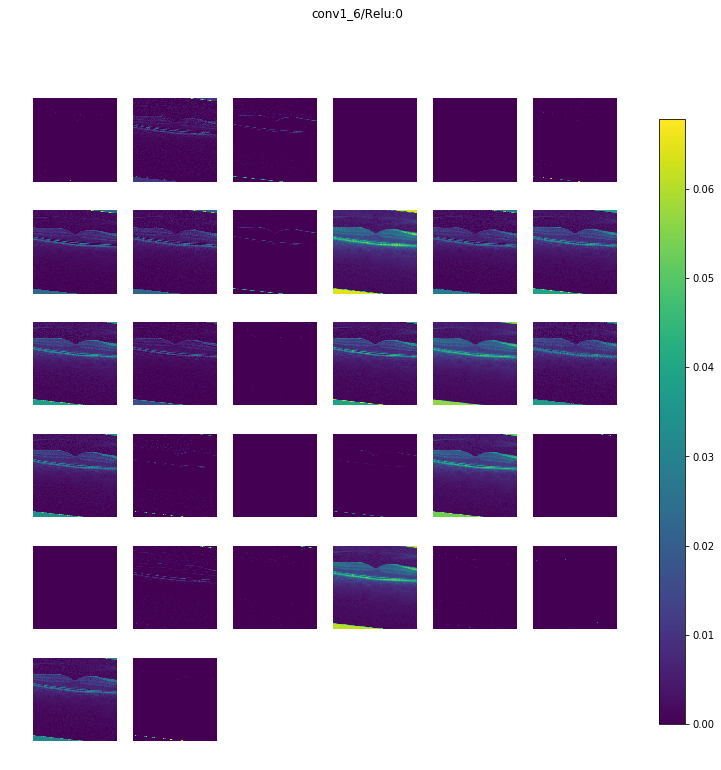

max_pooling2d_25/MaxPool:0 (1, 149, 149, 32) 


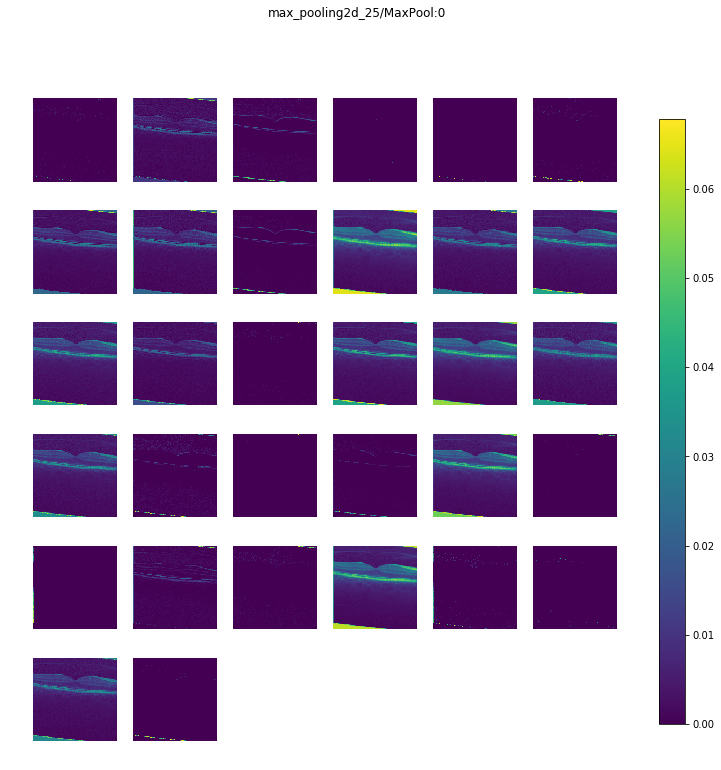

conv2d_21/Relu:0 (1, 147, 147, 32) 


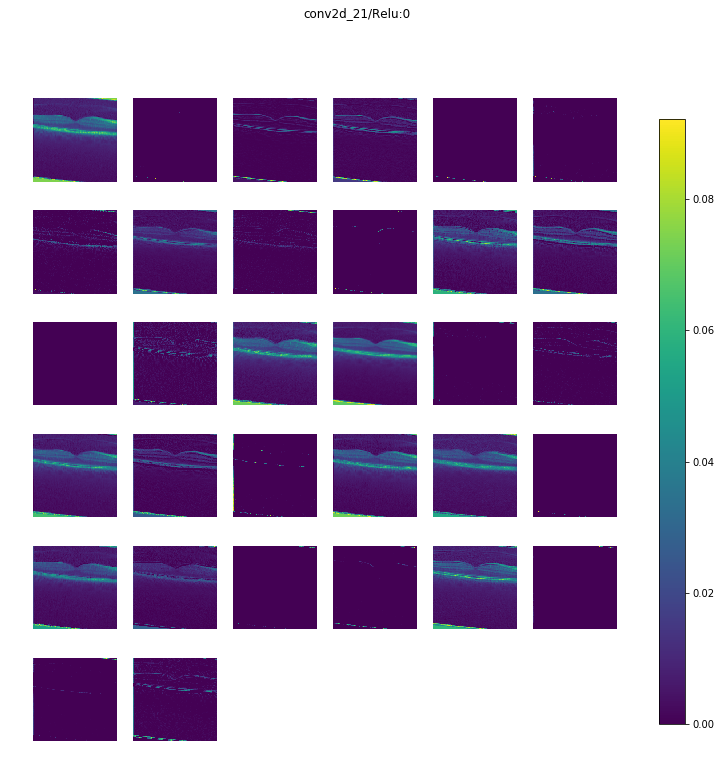

max_pooling2d_26/MaxPool:0 (1, 73, 73, 32) 


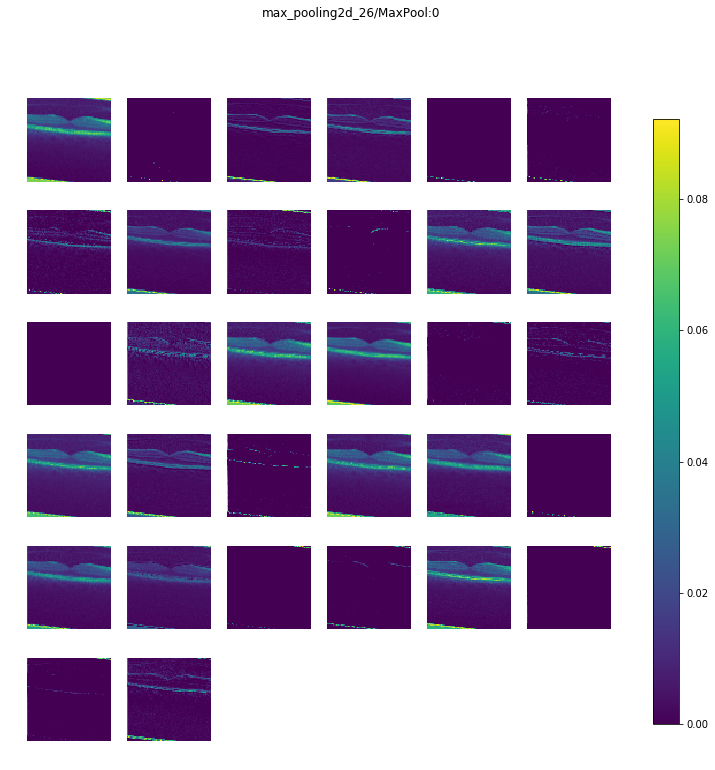

conv2d_22/Relu:0 (1, 71, 71, 64) 


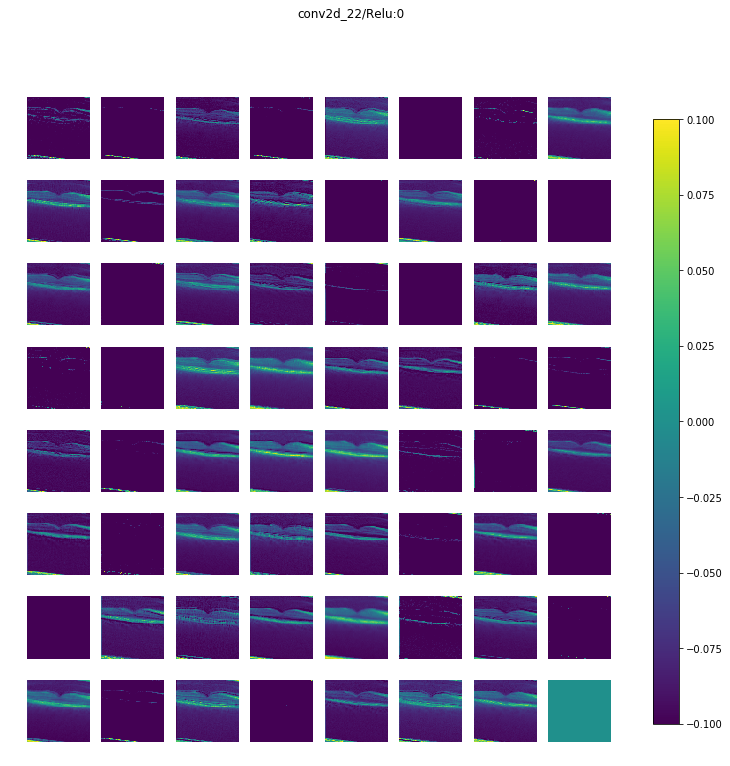

max_pooling2d_27/MaxPool:0 (1, 35, 35, 64) 


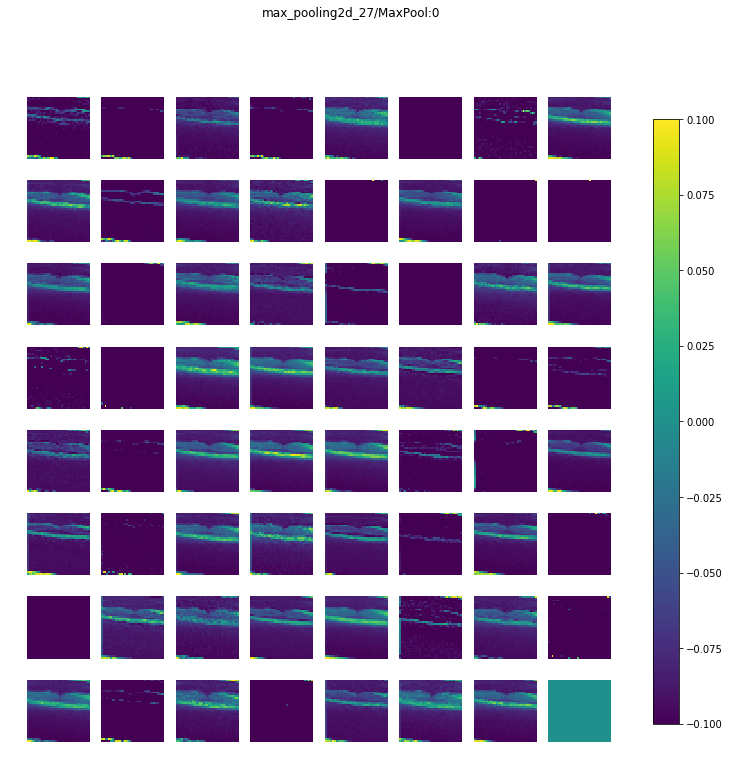

conv2d_23/Relu:0 (1, 33, 33, 64) 


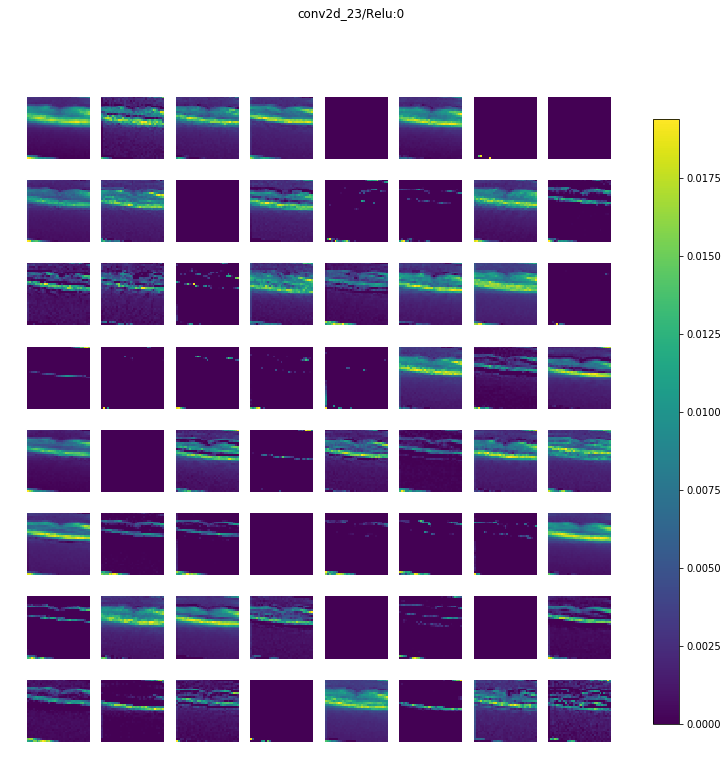

max_pooling2d_28/MaxPool:0 (1, 16, 16, 64) 


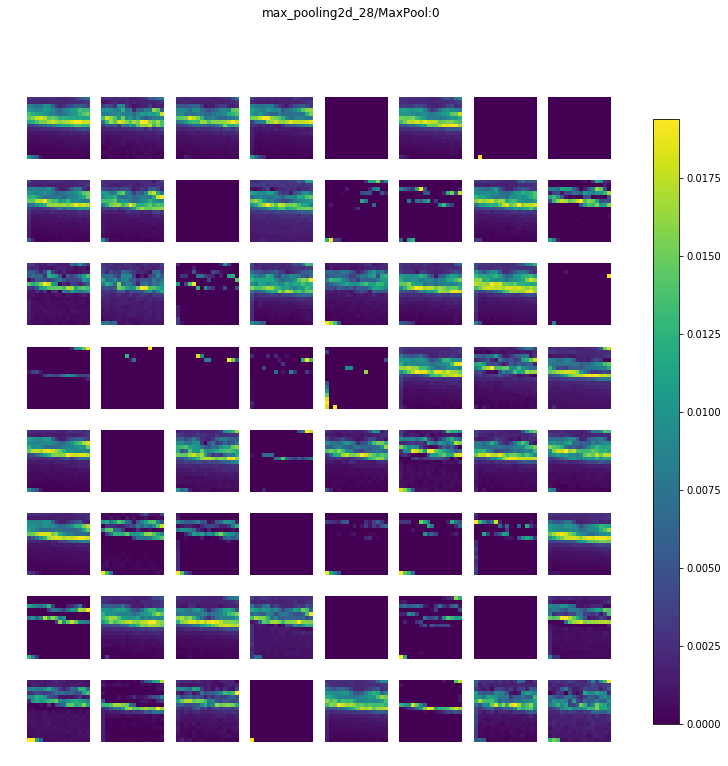

conv2d_24/Relu:0 (1, 14, 14, 128) 


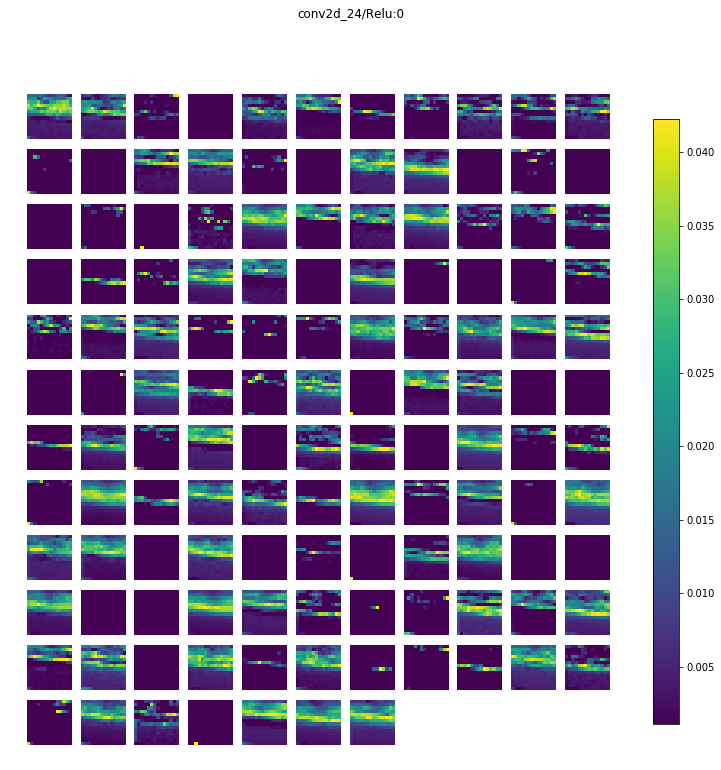

max_pooling2d_29/MaxPool:0 (1, 7, 7, 128) 


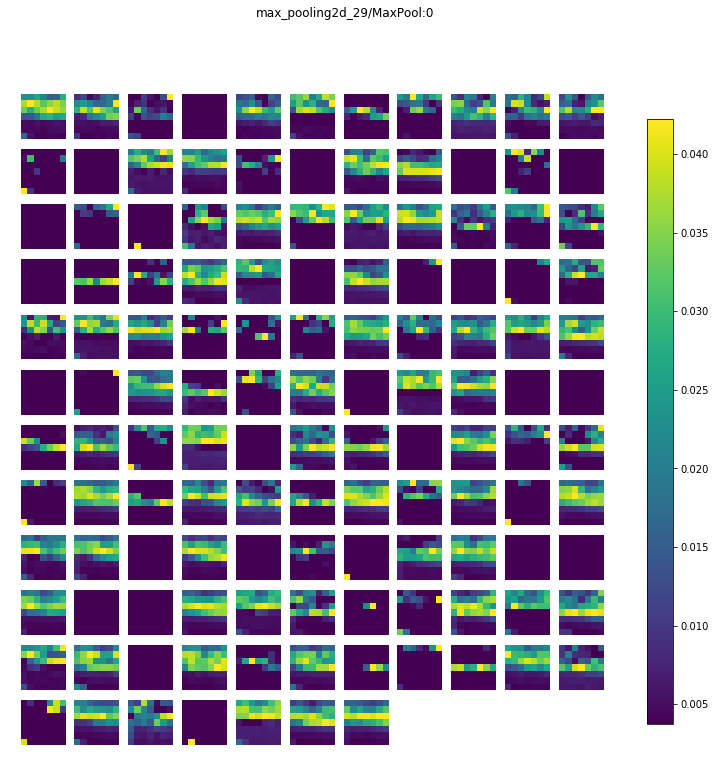

conv2d_25/Relu:0 (1, 5, 5, 128) 


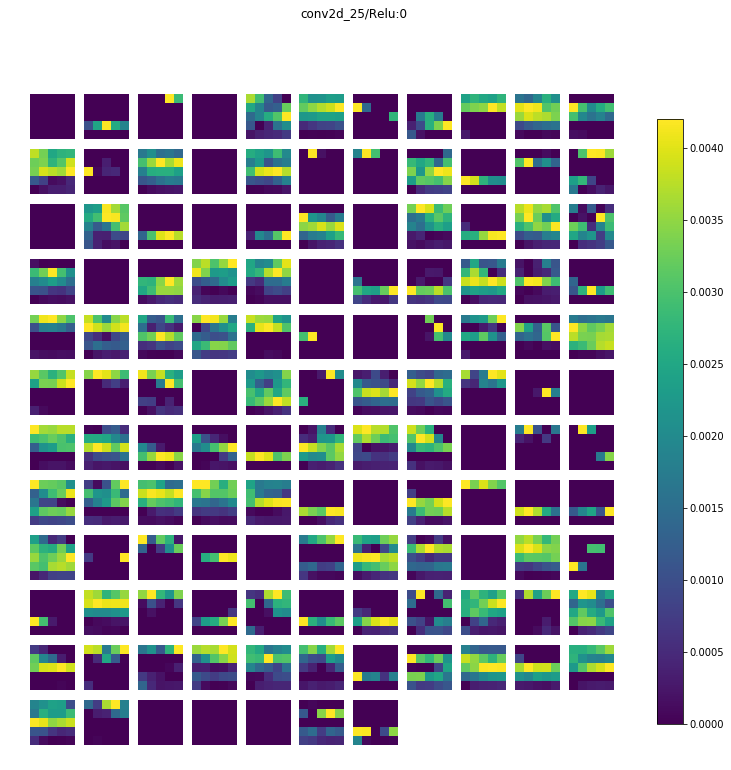

max_pooling2d_30/MaxPool:0 (1, 2, 2, 128) 


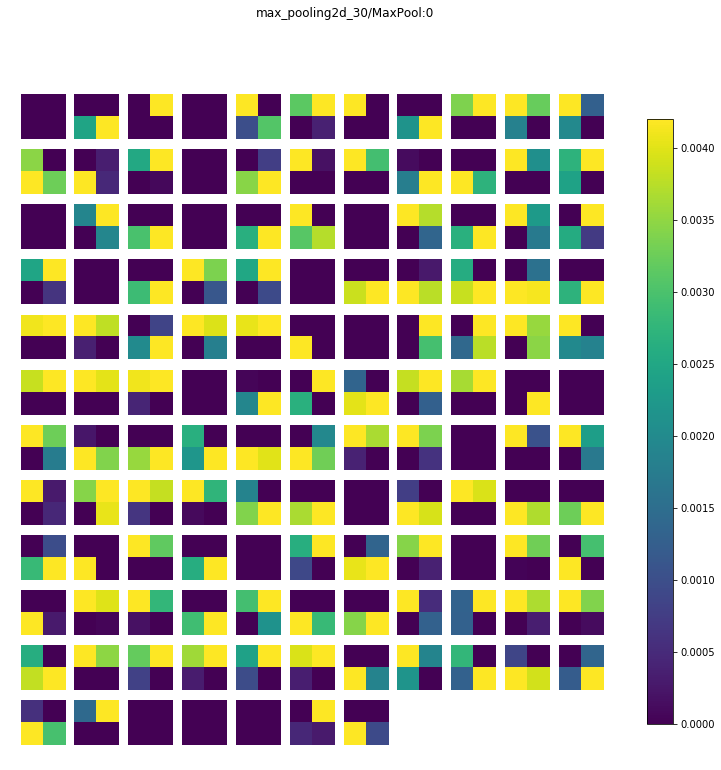

flatten_5/Reshape:0 (1, 512) -> Skipped. 2D Activations.
dropout_5/cond/Merge:0 (1, 512) -> Skipped. 2D Activations.
dense_5/Softmax:0 (1, 4) -> Skipped. 2D Activations.


In [49]:
from tensorflow.keras.optimizers import Adam
img_file=cv2.imread('/kaggle/input/dataset/Dataset/train/NORMAL/NORMAL-1001772-1.jpeg',cv2.IMREAD_GRAYSCALE)
image = skimage.transform.resize(img_file, (img_rows, img_cols), Image.ANTIALIAS)  
img=[]
img_arr = np.asarray(image)
img.append(img_arr)

im=np.asarray(img)
image = im.reshape(1,img_rows, img_cols ,1)
    
#print(image)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy','mse'])

activations = get_activations(model, image)
first = activations.get('conv1/Relu:0')
display_activations(activations)